In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
Player_Data = pd.read_csv('starcraft_player_data.csv')

# 1. Data Cleaning

In [4]:
Player_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

Checking datatypes of the columns reveals that Age, HoursPerWeek and TotalHours have mixed datatypes when I expect everything to be numeric, so I should expect to do some cleaning. Replacing non-numeric datatypes with NaNs:

In [5]:
Player_Data = Player_Data.apply(pd.to_numeric, errors='coerce')

In [6]:
Player_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3340 non-null   float64
 3   HoursPerWeek          3339 non-null   float64
 4   TotalHours            3338 non-null   float64
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

Age, HoursPerWeek and TotalHours appear as integers in the CSV file, but pandas has to treat them as floats to use pd.NA, it seems.

Seems like all Professional League games don't have an Age, HoursPerWeek or TotalHours recorded. However, there are only 55 professional games, and a different number of NaNs in each of these three columns. So, we see that 2 rows of the non-Professional games have missing data. The simplest solution is to discard those 2 entries rather than impute them, since they're so few. 

In [7]:
print(Player_Data.loc[Player_Data['LeagueIndex'] == 8].shape[0]) # Number of Professional games recorded
Pro_Player_Data = Player_Data.loc[Player_Data['LeagueIndex'] == 8]

55


In [8]:
# Drop the two rows with missing data from the non pro games
Player_Data.loc[Player_Data['LeagueIndex'] != 8] = Player_Data.loc[Player_Data['LeagueIndex'] != 8].dropna()

Next, plot the columns separated by LeagueIndex to make sure their values are reasonable.

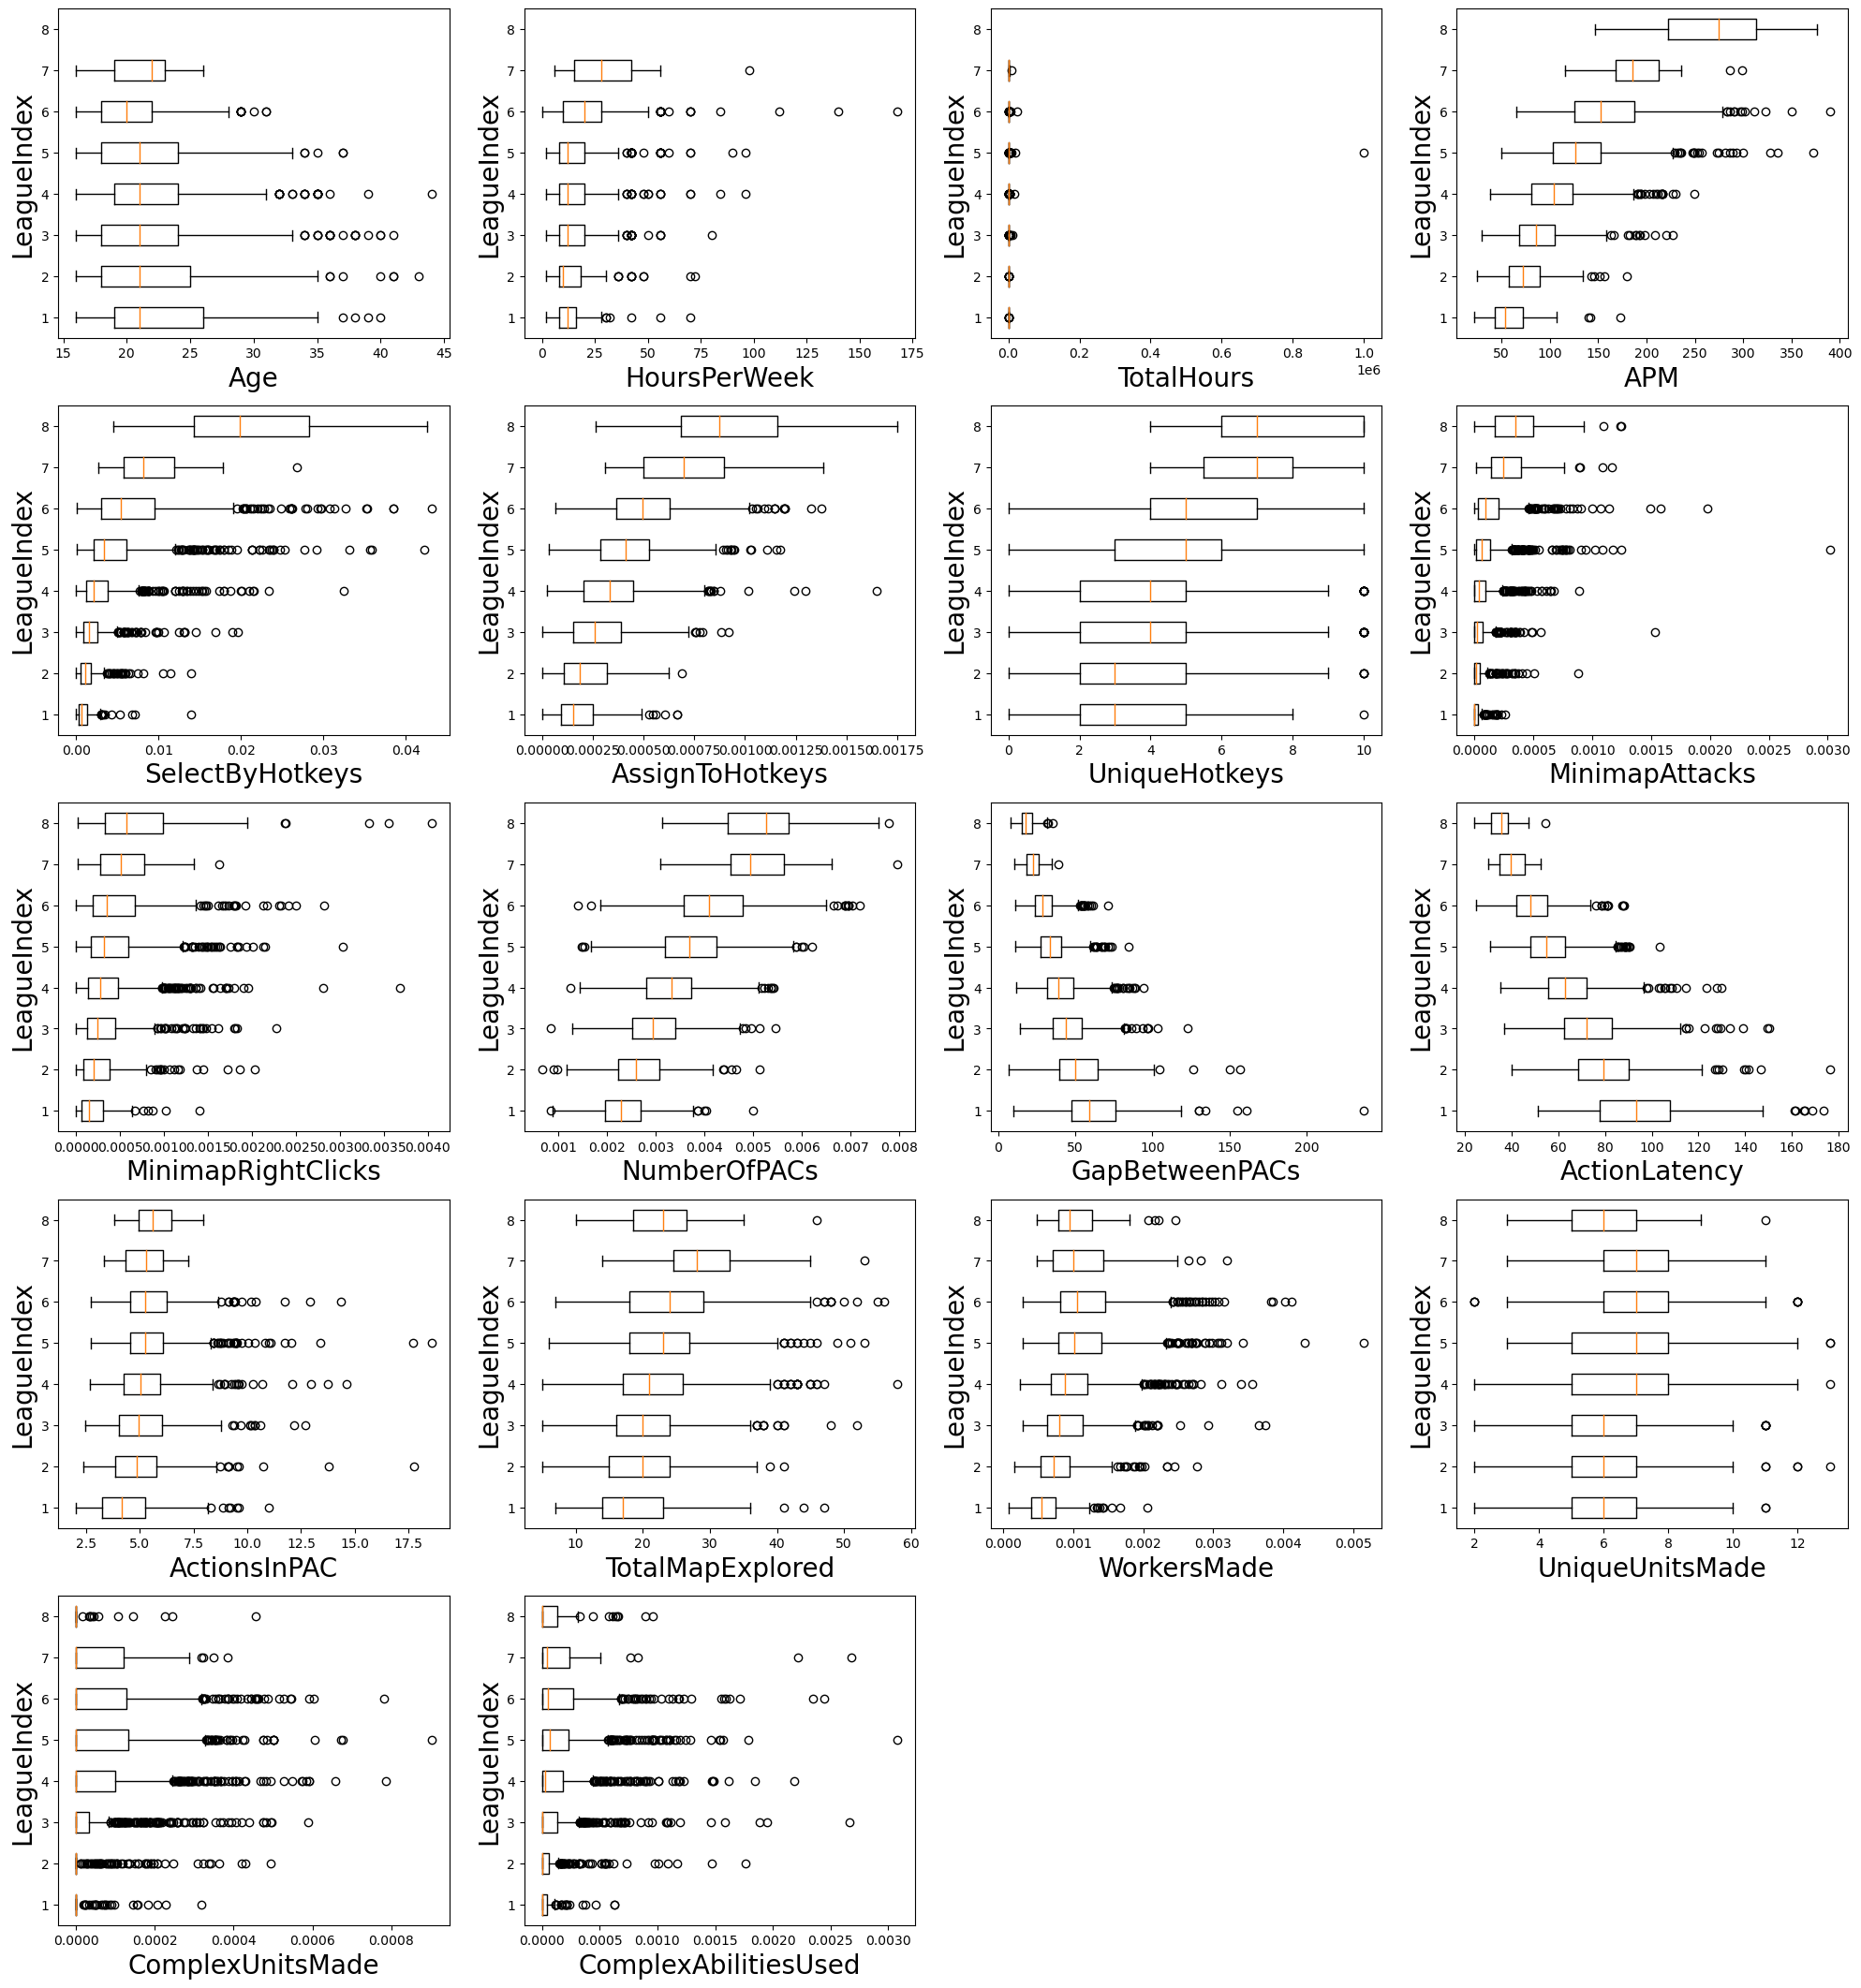

In [9]:
plt.figure(figsize=(20,25))
for i, col in enumerate(Player_Data.drop(['LeagueIndex', 'GameID'], axis=1).columns.tolist()):
  plt.subplot(6,4,1+i)
  plt.boxplot([Player_Data.loc[Player_Data["LeagueIndex"] == j][col].dropna() for j in (np.arange(8)+1)], vert=False)  
  plt.xlabel(col, fontsize=20)
  plt.ylabel("LeagueIndex", fontsize=20)
plt.tight_layout()

We should only cut the extreme outliers, as we are trying to predict the sorts of players that might be professional, which may produce exceptional data. However, exceptionally bad players could also produce exceptional data, so that should be kept in mind. There may also be Mid-level players with very unusual techniques. Also, at any level, there are always trolls! Therefore, I'm careful to eliminate many outliers. Just the ones that look like erratic techniques or if they don't make sense. I'd need to spend more time with Starcraft to determine exactly what threshold would indicate erratic techniques, but I'll just use my best guess for now.

In plot order, 

* HoursPerWeek -- column has some nearing the max 168. Seems like people should be doing other stuff at least 6*7 = 42 hours of the week, like sleeping and eating. Cut data with HoursPerWeek > 126
* Total Hours -- a few extreme outliers. Cut Total Hours > 15000
* MinimapAttacks -- a few major outliers. Cut > 0.0015 as it seems like an erratic technique to spend so many actions on minimap attacks.
* ActionsInPAC -- a few outliers. Cut > 15 as seems like an erratic technique to have so many actions in a PAC.
* WorkersMade -- One outlier that seems like a strange game in which way too many workers were made. Otherwise its a common thing I witness in Midrank AOE4 that people tend to overproduce workers, so others seem reasonable. Cut > 0.005
* UniqueUnitsMade & UniqueHotkeys -- It's a bit strange to me that these columns are populated by integers. I suspect it is actually not "per timestamp" as the project outline says, and instead is just the total number of unique units made or unique hotkeys used over the game. No cut
* ComplexUnitsMade -- Also seems a bit of a strange strategy to make so many complex units, so > 0.0006 seem like outlier games and are cut. 
* ComplexAbilitiesUsed -- Erratic techniques for so many complex abilities used, cut > 0.0020
* All other data seem fine

In [10]:
Player_Data = Player_Data[(Player_Data['HoursPerWeek'] < 126) &
                          (Player_Data['TotalHours'] < 15000) &
                          (Player_Data['MinimapAttacks'] < 0.0015) &
                          (Player_Data['ActionsInPAC'] < 15) &
                          (Player_Data['WorkersMade'] < 0.005) &
                          (Player_Data['ComplexUnitsMade'] < 0.0006) &
                          (Player_Data['ComplexAbilitiesUsed'] < 0.002)]
Player_Data = pd.concat([Player_Data, Pro_Player_Data])

Replotting to see if all outliers are taken care of.

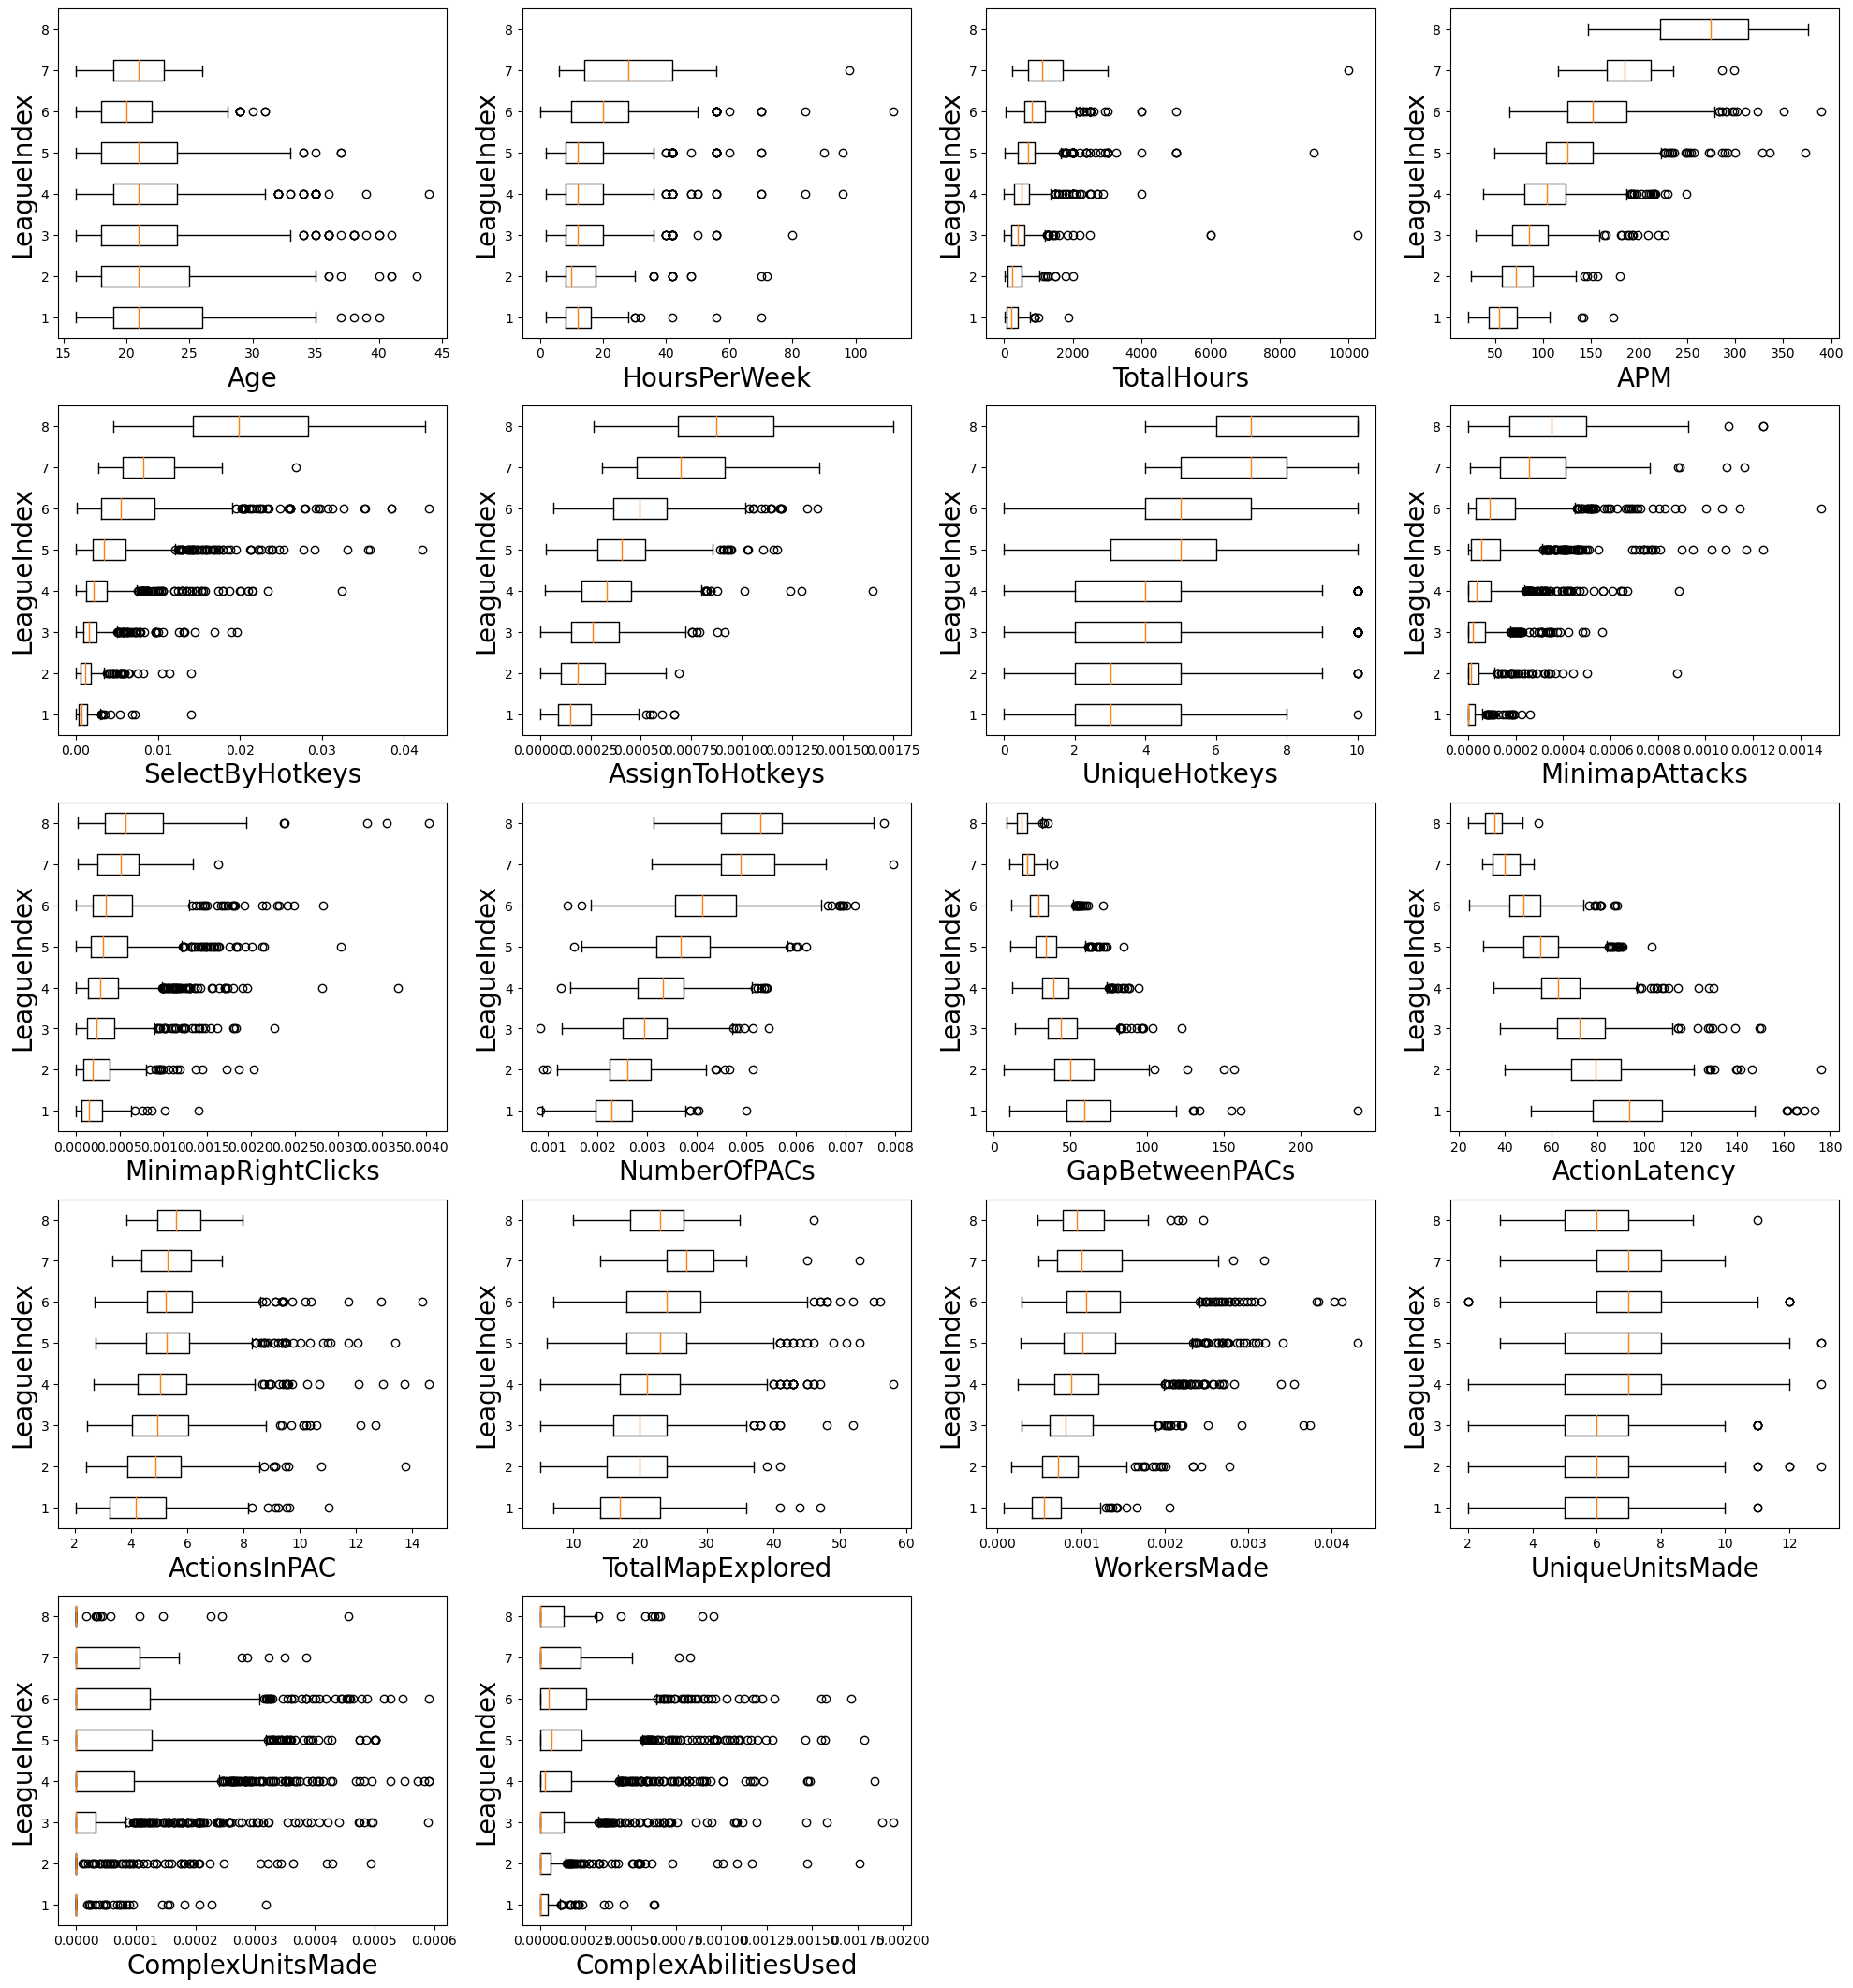

In [11]:
plt.figure(figsize=(20,25))
for i, col in enumerate(Player_Data.drop(['LeagueIndex', 'GameID'], axis=1).columns.tolist()):
  plt.subplot(6,4,1+i)
  plt.boxplot([Player_Data.loc[Player_Data["LeagueIndex"] == j][col].dropna() for j in (np.arange(8)+1)], vert=False)  
  plt.xlabel(col, fontsize=20)
  plt.ylabel("LeagueIndex", fontsize=20)
plt.tight_layout()

Data looks better. I might additionally drop ComplexAbilitiesUsed and ComplexUnitsMade, since they're filled with many zeros, and it looks like theres no pattern to the zeros across ranks, but I don't need to do that now. Let's now assess multicollinearity

# 2. Multicollinearity

In [12]:
# Using VIF to assess multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

We'll still focus on the NonPro data set as the Pro set contains NaNs, has such few data, and can be incorporated later.

In [13]:
# independent variable data
IV_Data = Player_Data.loc[Player_Data['LeagueIndex'] != 8].drop(['GameID','LeagueIndex'], axis=1)
  
# VIF dataframe
vif_df = pd.DataFrame()
vif_df["feature"] = IV_Data.columns
  
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(IV_Data.values, i)
                          for i in range(len(IV_Data.columns))]
vif_df

,feature,VIF
0,Age,29.457529
1,HoursPerWeek,3.580078
2,TotalHours,2.783271
3,APM,242.417677
4,SelectByHotkeys,21.066435
5,AssignToHotkeys,6.430398
6,UniqueHotkeys,5.767210
7,MinimapAttacks,1.660302
8,MinimapRightClicks,2.719861
9,NumberOfPACs,91.860701


The fact that some features are highly correlated with others make sense. However, it seems to me that having APM is redundant, when the info of APM could be nearly reconstructed from all the info on PACs. This is also suggested by the huge VIF for APM. So, it seems reasonable to drop the APM column.

Let's see if we can reduce multicollinearity to an acceptable level by subtracting the means and dropping APM.

In [14]:
IV_Data.drop('APM', axis=1, inplace=True)

In [15]:
# Subtracting the mean of the features
IV_means = IV_Data.mean()
IV_std = IV_Data.std()
Scaled_IV_Data = IV_Data - IV_means

In [16]:
# Computing VIFs for scaled data
# VIF dataframe
vif_df = pd.DataFrame()
vif_df["feature"] = IV_Data.columns
  
# calculating VIF for each feature
vif_df["VIF"] = [variance_inflation_factor(Scaled_IV_Data, i)
                          for i in range(len(IV_Data.columns))]
vif_df

,feature,VIF
0,Age,1.133283
1,HoursPerWeek,1.235270
2,TotalHours,1.283674
3,SelectByHotkeys,1.438983
4,AssignToHotkeys,1.609958
5,UniqueHotkeys,1.303588
6,MinimapAttacks,1.174252
7,MinimapRightClicks,1.269797
8,NumberOfPACs,5.693763
9,GapBetweenPACs,2.262767


This seems to be an acceptable level of VIF. Perhaps ActionLatency could be dropped if lower VIF were desired, as that info feels a bit redundant, too, but I don't feel confident enough in this feeling and would need to think about it more, and overall I don't think it's necessary to lower VIF further.

# 3. Most important features that predict a Player's rank

We can now identify which features are the most important for predicting a player's rank. Looking at the plots of the data above, we can get a good idea of which features are important for which ranks by eye.

Generally, NumberOfPACs, GapBetweenPACs, ActionLatency, AssignToHotkeys and SelectByHotkeys seem to be the most important features predicting a players rank. TotalHours and HoursPerWeek seem generally important, but less so. We dropped APM from our consideration as it's redundant and harmful for the predictive power of a model we might use, but it also corrolates with rank. It seems like hotkey usage/assignment is more important at higher ranks, and makes a big leap from non-pro to pro. We can see that making too many complex units, making too many workers, and using too many complex abilities are symptoms of midrank players.

We can check this intuition using a Random Forest and seeing what features it thinks are important. This seems like a good model to use to predict, too, as it is better capable to handle the NaNs of the pro players than other models, so I read. To use this model, we fill the NaNs of the pro players with the averages of the Grand Masters.

In [17]:
Scaled_NonPro_Data = pd.DataFrame(Scaled_IV_Data, columns=IV_Data.columns)
Scaled_NonPro_Data['LeagueIndex'] = Player_Data['LeagueIndex']
Scaled_NonPro_Data['GameID'] = Player_Data['GameID']

Scaled_Pro_Data = Pro_Player_Data
Scaled_Pro_Data.drop('APM', inplace=True, axis=1)

In [18]:
# scaling pro data, too. This shouldn't affect VIF much because so few data
for col in IV_Data.columns:
    Scaled_Pro_Data[col] = Pro_Player_Data[col] - IV_means[col]

# imputing pro NaN data as averages of GM data
GM_Means = Scaled_NonPro_Data.loc[Scaled_NonPro_Data['LeagueIndex'] == 7][['Age','TotalHours','HoursPerWeek']].mean()   

for col in ['Age','TotalHours','HoursPerWeek']:
    Scaled_Pro_Data[col] = GM_Means[col]

Scaled_Player_Data = pd.concat([Scaled_NonPro_Data, Scaled_Pro_Data])

In [19]:
from sklearn.ensemble import RandomForestClassifier
# Build RandomForest
X = Scaled_Player_Data.drop(['LeagueIndex','GameID'], axis=1)
y = Scaled_Player_Data['LeagueIndex']
# Train RandomForest
rf = RandomForestClassifier(max_depth=16, random_state=20, n_estimators = 1000).fit(X, y)
# Check Feature Importances

feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns,  columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                      importance
ActionLatency           0.110168
SelectByHotkeys         0.085319
TotalHours              0.080504
NumberOfPACs            0.080107
GapBetweenPACs          0.077288
AssignToHotkeys         0.068497
WorkersMade             0.062375
ActionsInPAC            0.058368
MinimapAttacks          0.057444
MinimapRightClicks      0.055498
HoursPerWeek            0.048001
TotalMapExplored        0.046474
Age                     0.044826
UniqueHotkeys           0.036278
ComplexAbilitiesUsed    0.035092
UniqueUnitsMade         0.031491
ComplexUnitsMade        0.022271


Messed around with the parameters and these importances seem relatively stable. Will also check correlations using linear fits as a lot of the IDVs seem to correlate linearly with the DV.

In [20]:
# Checking correlations of features with LeagueIndex
correlations = Scaled_Player_Data.drop('GameID', axis=1).corr()['LeagueIndex'].sort_values().drop('LeagueIndex')
print(correlations)

ActionLatency          -0.673695
GapBetweenPACs         -0.552534
Age                    -0.126219
UniqueUnitsMade         0.130168
ComplexAbilitiesUsed    0.141543
ComplexUnitsMade        0.144307
ActionsInPAC            0.148085
TotalMapExplored        0.216498
MinimapRightClicks      0.231441
HoursPerWeek            0.252956
WorkersMade             0.297462
MinimapAttacks          0.335652
UniqueHotkeys           0.349975
TotalHours              0.402827
SelectByHotkeys         0.491276
AssignToHotkeys         0.529105
NumberOfPACs            0.612302
Name: LeagueIndex, dtype: float64


Interpretation for general audience: 

The skill that Starcraft 2 players need most in order to progress in ranks is reaction time. This is the most important indicator of your rank: whether you are quick to determine what to do when you percieve a new situation unfolding in-game. Related to this, but a bit less important, is the rate at which you're percieving and reacting to situations on the map, along with how many actions you take in that reaction. For example, imagine the second you see your opponent is mounting a Zerg rush -- How quickly do you take your first action to turtle? This is most important. Then, how quickly and efficiently do you queue the appropriate units, set build orders, etc? These measures are not simply your APM, but are a metric of how efficiently and quickly you're acting on the map.

The next most important skill is utilizing more of the keyboard, assigning and selecting units and buildings by hotkeys. Better players use more hotkeys. And naturally, how long you've spent playing the game in total will be related to your skills in the game, since you can't hope to get better without playing. Finally, and this may be obvious, but better players are more on top of their economy, producing workers at a more optimal rate.

To summarize: to get better at Starcraft, 1) act faster and smarter, 2) use more of your keyboard, 3) put in the hours, and 4) keep on top of your economy!


# 4. Function to scout potential professionals

It seems like the problem of predicting someone's rank vs. predicting if someone could be a professional may need slightly different feature importances. However, we lack much pro data to use an ML approach to find feature importances as above.

So, using the importances gathered above, we'll construct a 'distance' function that weights the difference from the pros in each of these features according to the importances. Of course, if the non-Pro player surpasses (or not) a Pro player in a positively (negatively) correlated feature, that will count as a benefit. If the feature is uncorrelated, it will be penalized for any distance from the pro games. Since we have 55 pro games, we can easily take the average over all these games, then rank all the other nonpro games. We won't use Age, TotalHours or HoursPerWeek as this data wasn't given for Pro players. Since we know TotalHours is important, we'd use it as an afterthought to pick from those who appear to have the skills.

In [21]:
def feature_scores(game): # Compute feature scores of a non-pro game using the pro games, feature importances derived above, and correlation coefficients derived above.
    
    feature_scores=pd.DataFrame()
    # build up distance for each pro game
    for col in IV_Data.drop(['Age', 'TotalHours', 'HoursPerWeek'], axis=1).columns:
        score_list=[]
        for j in range(Scaled_Pro_Data.shape[0]):
            # Compute penalty/benefit based on correlation of feature. We normalize by std to make sure the features contribute with roughly equal importance before weighting them by feature_importances.
            if correlations[col] > 0.4:
                score_list.append(feature_importances.loc[col]['importance']*(game[col] - Scaled_Pro_Data.iloc[j][col]) / np.absolute(IV_std[col]))
            elif correlations[col] < -0.4:
                score_list.append(feature_importances.loc[col]['importance']*(Scaled_Pro_Data.iloc[j][col] - game[col]) / np.absolute(IV_std[col]))
            else:
                score_list.append(- feature_importances.loc[col]['importance']*np.absolute(Scaled_Pro_Data.iloc[j][col] - game[col]) / np.absolute(IV_std[col]))
                
        feature_scores[col+'Score']=[sum(score_list)/Scaled_Pro_Data.shape[0]]
    feature_scores['TotalProScore']=[sum(feature_scores.iloc[0])]
    feature_scores['GameID']=[game['GameID']]
    return feature_scores

In [22]:
# dataframe of scores for non-pro player games, sorted by overall score
ranked = feature_scores(Scaled_NonPro_Data.iloc[0])
for j in range(1, Scaled_NonPro_Data.shape[0]):
    ranked = pd.concat([ranked, feature_scores(Scaled_NonPro_Data.iloc[j])])
ranked.set_index('GameID')
ranked = ranked.sort_values(by='TotalProScore', ascending=False)

Here are the top 10 Grand Master games as ranked by this function

In [23]:
from operator import add
importance_scores = list(map(add, feature_importances.drop(['Age','TotalHours','HoursPerWeek']).index.tolist(), ['Score']*len( feature_importances.index.tolist())))
importance_scores.insert(0,"TotalProScore")

In [24]:
top_10 = ranked.head(10)
top_10.set_index('GameID')[importance_scores]

,TotalProScore,ActionLatencyScore,SelectByHotkeysScore,NumberOfPACsScore,GapBetweenPACsScore,AssignToHotkeysScore,WorkersMadeScore,ActionsInPACScore,MinimapAttacksScore,MinimapRightClicksScore,TotalMapExploredScore,UniqueHotkeysScore,ComplexAbilitiesUsedScore,UniqueUnitsMadeScore,ComplexUnitsMadeScore
GameID,,,,,,,,,,,,,,,
2783.0,-0.302901,-0.009231,0.257543,-0.002103,0.027920,-0.115863,-0.046806,-0.050047,-0.114038,-0.083658,-0.038939,-0.028593,-0.066406,-0.027176,-0.005505
2143.0,-0.346059,0.016506,0.316456,0.016785,-0.024811,-0.087844,-0.122677,-0.043534,-0.151754,-0.128493,-0.047820,-0.041333,-0.020110,-0.021926,-0.005505
8526.0,-0.428652,0.006424,0.093434,0.059822,-0.010947,-0.080831,-0.039029,-0.038327,-0.110447,-0.083947,-0.033588,-0.052091,-0.058448,-0.066396,-0.014281
4754.0,-0.449267,0.031258,-0.096510,0.103951,0.000864,0.025370,-0.066418,-0.055039,-0.086615,-0.167979,-0.035068,-0.041333,-0.020110,-0.036132,-0.005505
6531.0,-0.449774,0.022360,-0.223189,0.057406,0.013483,0.084220,-0.041650,-0.034228,-0.106553,-0.089876,-0.037004,-0.041333,-0.020110,-0.027794,-0.005505
2606.0,-0.464821,-0.044761,0.071207,-0.065869,-0.040860,0.083241,-0.041182,-0.035713,-0.095721,-0.089042,-0.043380,-0.041333,-0.088726,-0.027176,-0.005505
8239.0,-0.470817,0.036794,-0.214803,0.144213,-0.004219,0.068311,-0.039912,-0.034067,-0.148848,-0.094753,-0.067404,-0.028593,-0.023862,-0.050029,-0.013646
6964.0,-0.485792,0.024759,-0.099412,0.117839,0.003690,-0.043641,-0.062486,-0.039447,-0.089409,-0.086444,-0.067404,-0.030575,-0.044360,-0.036132,-0.032770
9124.0,-0.501263,-0.078485,0.386197,-0.089661,-0.064414,-0.153058,-0.047900,-0.046517,-0.148920,-0.117337,-0.038939,-0.030575,-0.024814,-0.027794,-0.019046


This set of Grand Master players makes sense because they're at the same level as the pro players in terms of the important features that predict LeagueIndex. See the following plots, in descending order of feature importance. I might do some sort of distribution tests to get metrics on the populations' distinguishability, but seems unnecessary at the moment. The prospective pros look all within the same level of performance as the pros.

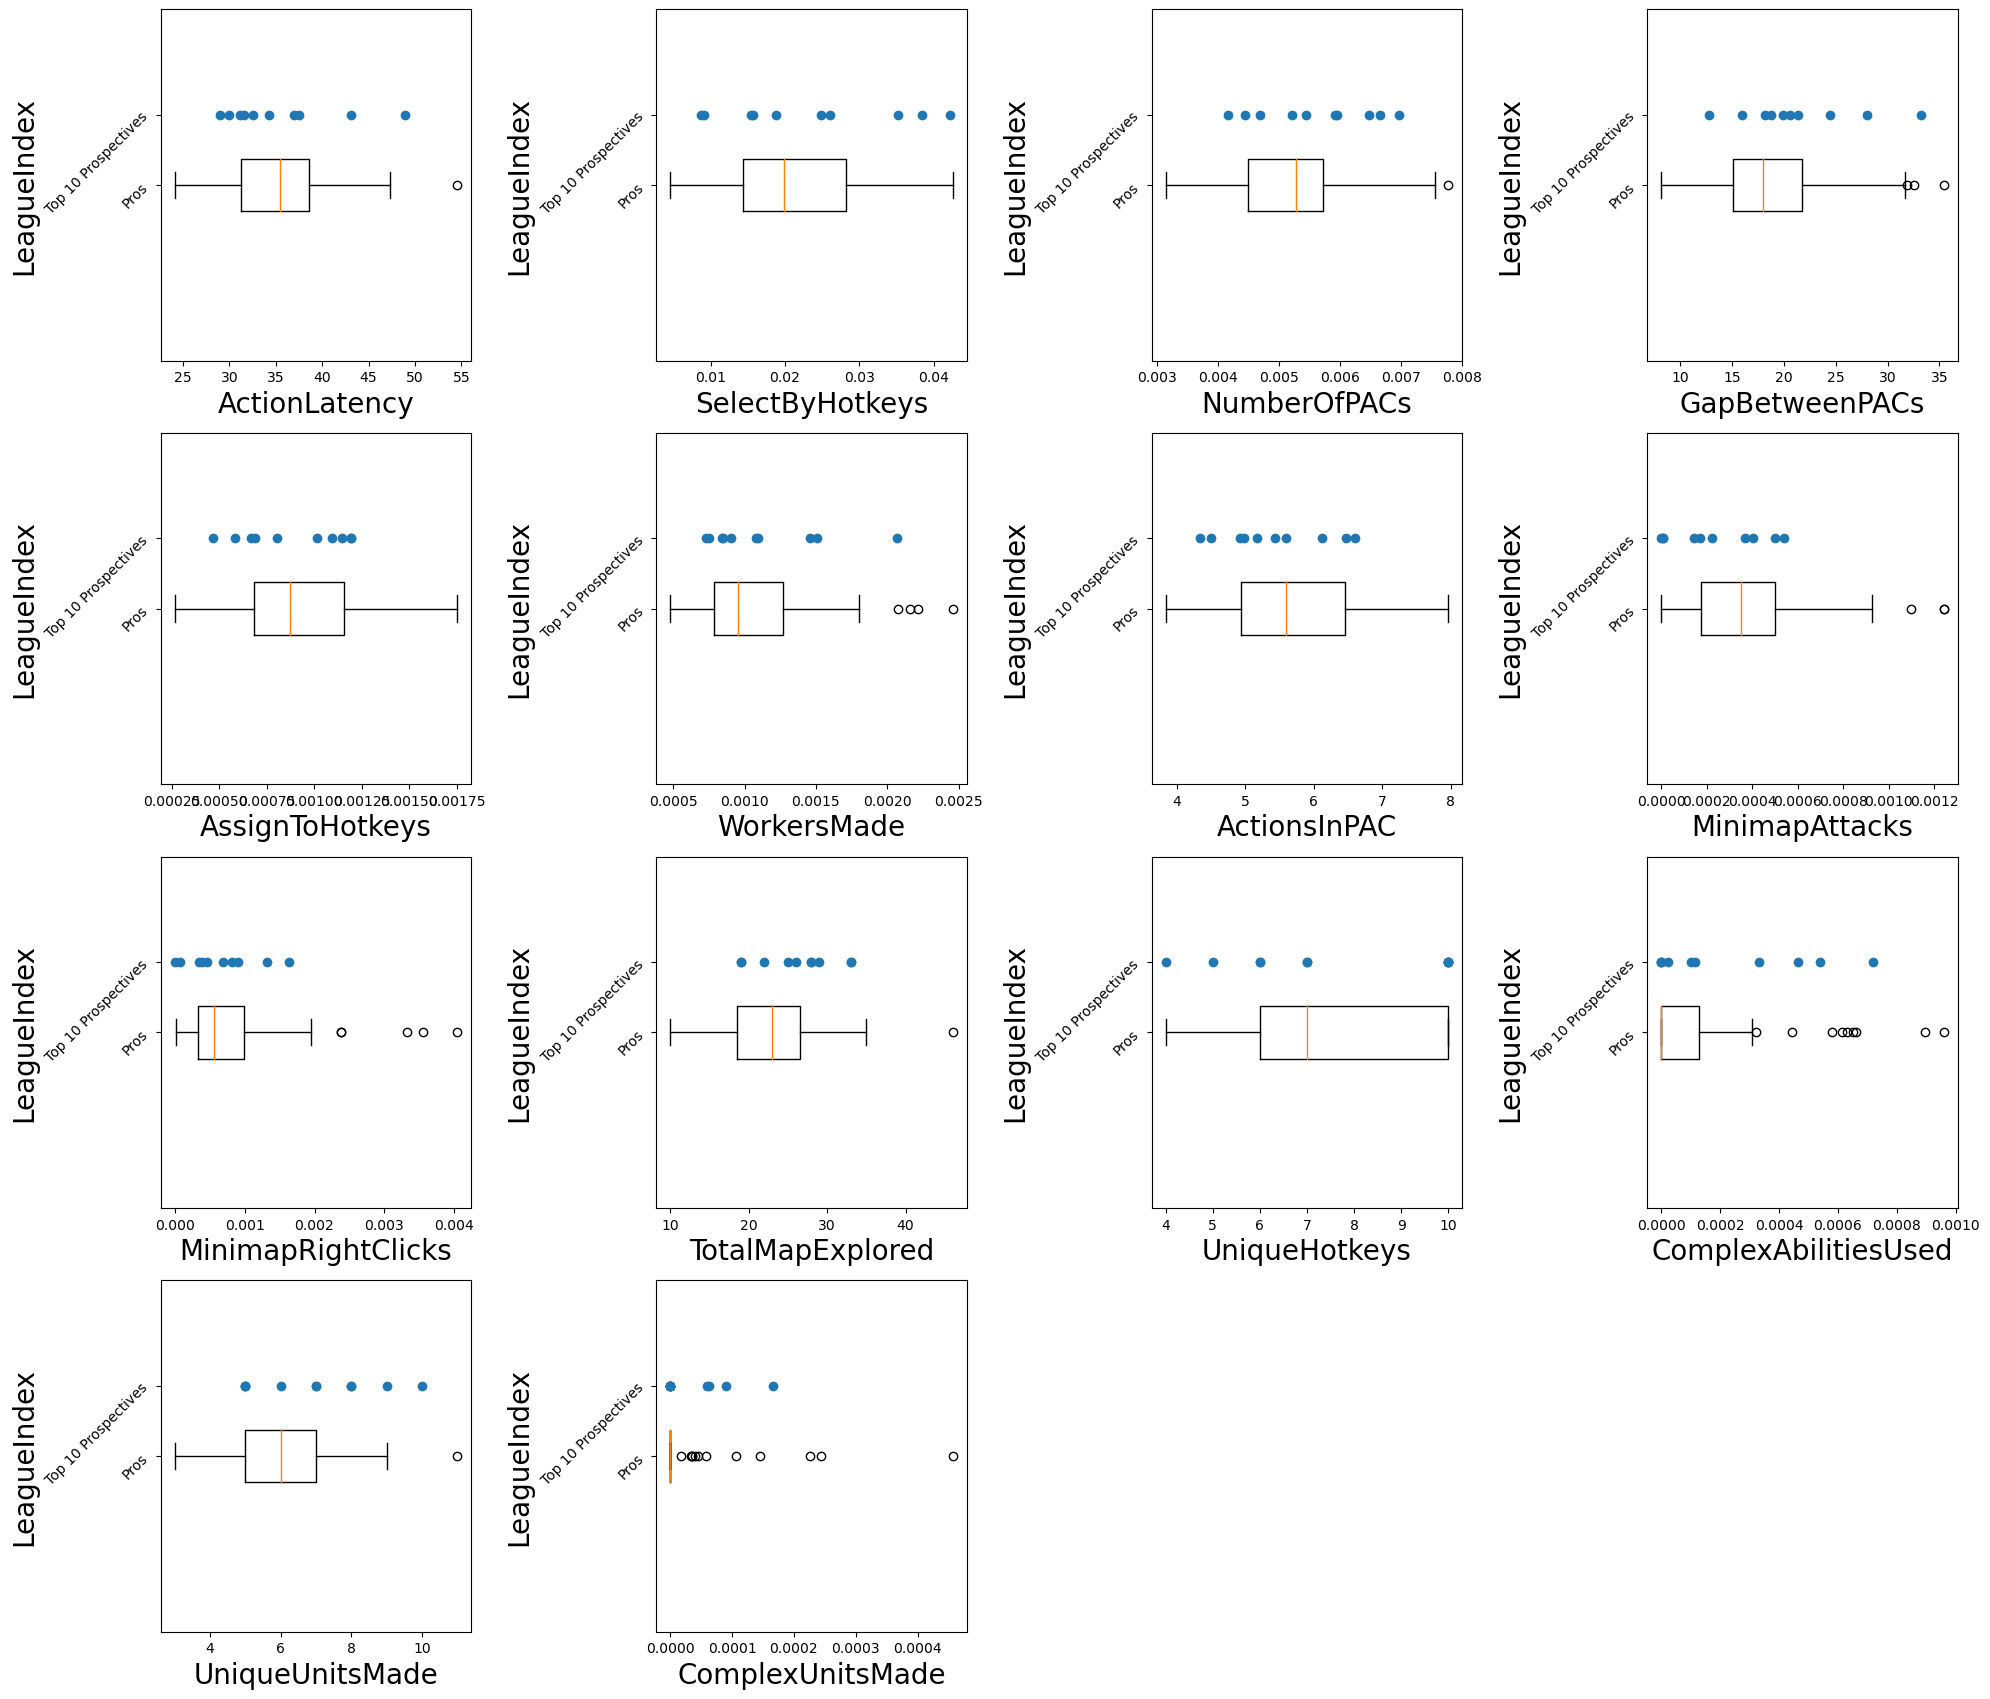

In [25]:
plt.figure(figsize=(20,25))
for i, col in enumerate(feature_importances.index.drop(['Age','HoursPerWeek','TotalHours']).tolist()):
  plt.subplot(6,4,1+i)
  plt.scatter(Player_Data.loc[Player_Data['GameID'].isin(top_10['GameID'])][col], [1.2]*10 )
  plt.boxplot(Player_Data.loc[Player_Data['LeagueIndex']==8][col].dropna(), vert=False)  
  plt.xlabel(col, fontsize=20)
  plt.ylabel("LeagueIndex", fontsize=20)
  plt.yticks([1, 1.2], ['Pros', 'Top 10 Prospectives'],
       rotation=45)
plt.tight_layout()

# 5. Hypothetically predicting LeagueIndex

If I were to create a model to predict LeagueIndex I'd start by considering Logistic Regression, as LeagueIndex is an ordinal dependent variable and Logistic Regression is a simple method. Since a lot of the important relationships of the IDVs with LeagueIndex are mostly linear, I expect it to be an effective method, too. However, the nonlinear relationships seen in, say, WorkersMade might not be well captured. I'd therefore also want to develop further the Random Forest model as I expect it would do better with the nonlinear relationships, and compare the two models' performance.